In [2]:
import sys
import os

# Manually set root if in notebook
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)

In [11]:
import torch
import tiktoken
import re
from datetime import datetime

from datasets.loader import get_data_loaders
from datasets.instruction import format_input

from inference.generate import text_to_token_ids, token_ids_to_text

from models.gpt2.gpt_model_v1 import GPTModel
from models.gpt2.config import BASE_CONFIG, model_configs, CHOOSE_MODEL
from scripts.gpt2.train import train_model_simple
from utils.loader import download_and_load_file
from utils.gpt2_utils import *
from utils.gpt2_utils import download_and_load_gpt2

from inference.generate import generate_and_print_sample



In [5]:
# Load dataset
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)

In [6]:
# Split data
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [7]:
# Load Tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

In [8]:
# Model
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].strip("()")
settings, params = download_and_load_gpt2(model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

# Load to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [9]:
# Loaders
train_loader, val_loader, _ = get_data_loaders(train_data, val_data, test_data, tokenizer, device)

In [10]:
# Training
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

In [13]:
train_losses, val_losses, tokens_seen  = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=2, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
    sample_fn=generate_and_print_sample
)


Ep 1 (Step 000000): Train loss 0.311, Val loss 0.650
Ep 1 (Step 000005): Train loss 0.301, Val loss 0.666
Ep 1 (Step 000010): Train loss 0.316, Val loss 0.702
Ep 1 (Step 000015): Train loss 0.286, Val loss 0.714
Ep 1 (Step 000020): Train loss 0.316, Val loss 0.723
Ep 1 (Step 000025): Train loss 0.282, Val loss 0.719
Ep 1 (Step 000030): Train loss 0.305, Val loss 0.708
Ep 1 (Step 000035): Train loss 0.272, Val loss 0.699
Ep 1 (Step 000040): Train loss 0.265, Val loss 0.704
Ep 1 (Step 000045): Train loss 0.266, Val loss 0.710
Ep 1 (Step 000050): Train loss 0.270, Val loss 0.694
Ep 1 (Step 000055): Train loss 0.251, Val loss 0.690
Ep 1 (Step 000060): Train loss 0.260, Val loss 0.692
Ep 1 (Step 000065): Train loss 0.253, Val loss 0.687
Ep 1 (Step 000070): Train loss 0.238, Val loss 0.683
Ep 1 (Step 000075): Train loss 0.261, Val loss 0.678
Ep 1 (Step 000080): Train loss 0.256, Val loss 0.681
Ep 1 (Step 000085): Train loss 0.274, Val loss 0.670
Ep 1 (Step 000090): Train loss 0.250, Val loss

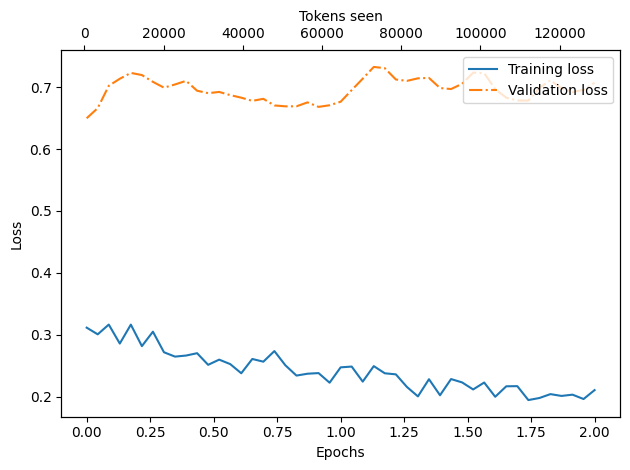

In [14]:
from utils.plots import plot_losses
epochs_tensor = torch.linspace(0, 2, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [15]:
torch.manual_seed(123)

from inference.generate import generate
for entry in test_data[:3]:      #1
    input_text = format_input(entry)
    token_ids = generate(               #2
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bull in a china shop.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cirrus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author o